In [144]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/Shareddrives/SnP_DATA/AI_Team/SuNT/AI_PRACTICE/text-generation/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Concatenate, TimeDistributed
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from attention import AttentionLayer

### Prepare dataset

In [146]:
%cd /content/drive/Shareddrives/SnP_DATA/AI_Team/SuNT/AI_PRACTICE/text-generation/

/content/drive/Shareddrives/SnP_DATA/AI_Team/SuNT/AI_PRACTICE/text-generation


In [147]:
with open('poem_all.txt','r') as f:
  data = f.read()

In [148]:
data_list = []
data_list = [line for line in data.split('\n') if line != '' and line not in data_list]
data_list[:10]

['Trăm năm trong cõi người ta',
 'Chữ tài chữ mệnh khéo là ghét nhau',
 'Trải qua một cuộc bể dâu',
 'Những điều trông thấy mà đau đớn lòng',
 'Lạ gì bỉ sắc tư phong',
 'Trời xanh quen thói má hồng đánh ghen',
 'Cảo thơm lần giở trước đèn',
 'Phong tình có lục còn truyền sử xanh',
 'Rằng năm Gia Tĩnh triều Minh',
 'Bốn phương phẳng lặng hai kinh vững vàng']

In [149]:
data_list = [x.lower() for x in data_list]
data_list[:10]

['trăm năm trong cõi người ta',
 'chữ tài chữ mệnh khéo là ghét nhau',
 'trải qua một cuộc bể dâu',
 'những điều trông thấy mà đau đớn lòng',
 'lạ gì bỉ sắc tư phong',
 'trời xanh quen thói má hồng đánh ghen',
 'cảo thơm lần giở trước đèn',
 'phong tình có lục còn truyền sử xanh',
 'rằng năm gia tĩnh triều minh',
 'bốn phương phẳng lặng hai kinh vững vàng']

In [150]:
remove_punc = str.maketrans('', '', string.punctuation)
removed_punc_text = []
for sent in data_list:
  sentance = [w.translate(remove_punc) for w in sent.split(' ')]
  removed_punc_text.append(' '.join(sentance))
tk_text_ = removed_punc_text
tk_text_[:10]

['trăm năm trong cõi người ta',
 'chữ tài chữ mệnh khéo là ghét nhau',
 'trải qua một cuộc bể dâu',
 'những điều trông thấy mà đau đớn lòng',
 'lạ gì bỉ sắc tư phong',
 'trời xanh quen thói má hồng đánh ghen',
 'cảo thơm lần giở trước đèn',
 'phong tình có lục còn truyền sử xanh',
 'rằng năm gia tĩnh triều minh',
 'bốn phương phẳng lặng hai kinh vững vàng']

In [151]:
remove_digits = str.maketrans('', '', string.digits)
removed_digits_text = []
for sent in tk_text_:
    sentance = [w.translate(remove_digits) for w in sent.split(' ')]
    removed_digits_text.append(' '.join(sentance))
tk_text_ = removed_digits_text
tk_text_[:10]

['trăm năm trong cõi người ta',
 'chữ tài chữ mệnh khéo là ghét nhau',
 'trải qua một cuộc bể dâu',
 'những điều trông thấy mà đau đớn lòng',
 'lạ gì bỉ sắc tư phong',
 'trời xanh quen thói má hồng đánh ghen',
 'cảo thơm lần giở trước đèn',
 'phong tình có lục còn truyền sử xanh',
 'rằng năm gia tĩnh triều minh',
 'bốn phương phẳng lặng hai kinh vững vàng']

In [152]:
# removing the starting and ending whitespaces
tk_text_ = [st.strip() for st in tk_text_]
tk_text_[:10]

['trăm năm trong cõi người ta',
 'chữ tài chữ mệnh khéo là ghét nhau',
 'trải qua một cuộc bể dâu',
 'những điều trông thấy mà đau đớn lòng',
 'lạ gì bỉ sắc tư phong',
 'trời xanh quen thói má hồng đánh ghen',
 'cảo thơm lần giở trước đèn',
 'phong tình có lục còn truyền sử xanh',
 'rằng năm gia tĩnh triều minh',
 'bốn phương phẳng lặng hai kinh vững vàng']

In [153]:
# remove … and – character
tk_text_ = [st.replace('…', '') for st in tk_text_]
tk_text_ = [st.replace('– ', '') for st in tk_text_]

In [154]:
# check to see if there is 2 sentences are same line
for ins in tk_text_:
    if len(ins.split()) > 12:
      print(ins)

In [155]:
# create pair of input/output sequence
input_sentences, target_sentences = [], []
for index, seq_txt in enumerate(tk_text_):
    if index%2 == 0:
        input_sentences.append(seq_txt)
    else:
        target_sentences.append(seq_txt)

In [156]:
len(input_sentences), len(target_sentences)

(3245, 3245)

In [157]:
# add start and end token to target sequences
target_sentences = ['start '+ ts + ' end' for ts in target_sentences]

In [158]:
# prepare the tokenizer on the input sentence
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_sentences)
# determine the vocabulary size
input_vocab_size = len(input_tokenizer.word_index) + 1
print('Input Vocabulary Size: %d' % input_vocab_size)
# create word2index dictionary
input_word2index = input_tokenizer.word_index
# create index2word dictionary
input_index2word = input_tokenizer.index_word

Input Vocabulary Size: 2551


In [159]:
# perform tokenize on input setences
input_seq = input_tokenizer.texts_to_sequences(input_sentences)
max_len_input_seq = max([len(seq) for seq in input_seq])
input_seq = pad_sequences(input_seq, maxlen=max_len_input_seq, padding='pre')
input_seq[:10]

array([[   0,    0,    0,    0,  204,   45,   11,  621,   10,   46],
       [   0,    0,    0,    0,  539,   77,    3,  222,  261,  366],
       [   0,    0,    0,    0,  233,  282, 1298,  234,  401,  191],
       [   0,    0,    0,    0, 1677,  540,  127,  541,   96,  402],
       [   0,    0,    0,    0,    6,   45,  205, 1299,  813,  247],
       [   0,    0,    0,    0,   22,   52, 1300,  704,  433,  192],
       [   0,    0,    0,    0,    3,  814,   57,  953, 1678,    9],
       [   0,    0,    0,    0,  136,    9,   51,  954, 1087,  705],
       [   0,    0,    0,    0,  107,  815,  344,  816,  542,  452],
       [   0,    0,    0,    0,  543,  345,  403,  706,  955,  404]],
      dtype=int32)

In [160]:
# prepare the tokenizer on the target sentence
target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(target_sentences)
# determine the vocabulary size
target_vocab_size = len(target_tokenizer.word_index) + 1
print('Target Vocabulary Size: %d' % target_vocab_size)
# create word2index dictionary
target_word2index = target_tokenizer.word_index
# create index2word dictionary
target_index2word = target_tokenizer.index_word

Target Vocabulary Size: 2588


In [161]:
# perform tokenize on target setences
target_seq = target_tokenizer.texts_to_sequences(target_sentences)
max_len_target_seq = max([len(seq) for seq in target_seq])
target_seq = pad_sequences(target_seq, maxlen=max_len_target_seq, padding='pre')
target_seq[:10]

array([[   0,    0,    0,    0,    1,  148,  296,  148,  484,  439,   11,
        1403,   34,    2],
       [   0,    0,    0,    0,    1,   63,  155,  122,   72,   24,   73,
         627,    6,    2],
       [   0,    0,    0,    0,    1,   52,  108,  361,  872,  297,   69,
         628,  519,    2],
       [   0,    0,    0,    0,    1,  243,    5,   13,  873,   14,  990,
        1773,  108,    2],
       [   0,    0,    0,    0,    1,  167,  404, 1774,  281,   46,  312,
         991,   56,    2],
       [   0,    0,    0,    0,    1,  520,  768,  208,   12,  337,  337,
        1775,  992,    2],
       [   0,    0,    0,    0,    1,  130,  282,   11,  148,  629,  230,
        1404,  520,    2],
       [   0,    0,    0,    0,    1,  874,  440,   11,  338,    3,   11,
         874,  362,    2],
       [   0,    0,    0,    0,    1,    4,    8,    4,  566,  197,  521,
         696,  197,    2],
       [   0,    0,    0,    0,    1,  769,  104,  168, 1776,  567, 1405,
         485, 140

In [162]:
# create encoder/decoder input/output
encoder_input_data = np.zeros((len(input_sentences), max_len_input_seq), dtype='float32')
decoder_input_data = np.zeros((len(target_sentences), max_len_target_seq),dtype='float32')
decoder_target_data = np.zeros((len(target_sentences), max_len_target_seq, target_vocab_size), dtype='float32')

# init encoder/decoder input/output
for i, (input_text, target_text) in enumerate(zip(input_sentences, target_sentences)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_word2index[word]
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_word2index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_word2index[word]] = 1.

### Define model

In [163]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 50

In [164]:
# Encoder 
encoder_inputs = Input(shape=(max_len_input_seq,)) 
enc_emb = Embedding(input_vocab_size, latent_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

In [165]:
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(target_vocab_size, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

In [166]:
#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

In [167]:
# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [168]:
#Dense layer
decoder_dense = TimeDistributed(Dense(target_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

In [169]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 50)       127550      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10, 50), (No 20200       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [170]:
# compile model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

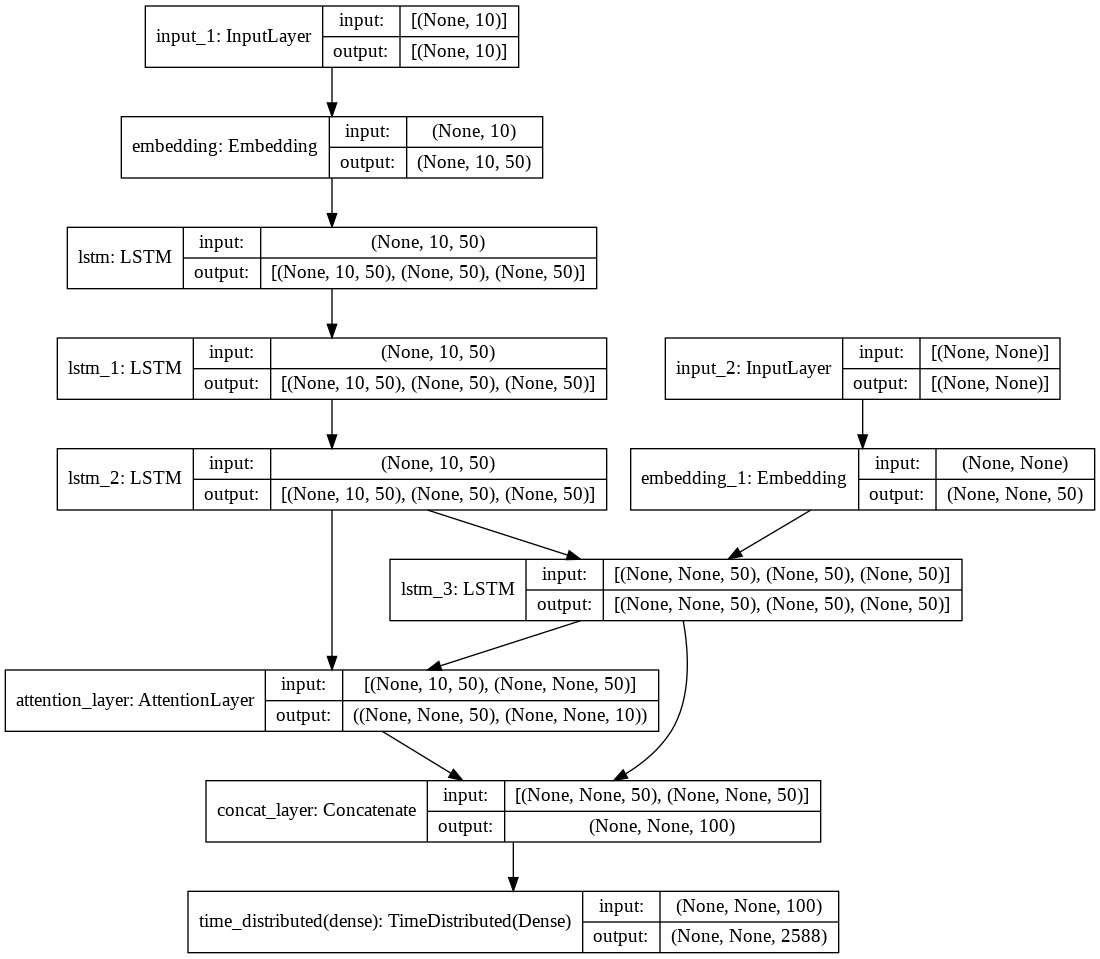

In [171]:
# plot model
plot_model(model, to_file='output/model_arch.png', show_shapes=True)

In [173]:
history = model.fit(
    x=[encoder_input_data, decoder_input_data],
    y=decoder_target_data,
    batch_size=64,
    epochs=1000)

Epoch 1/1000
51/51 [==============================] - 3s 56ms/step - loss: 3.3023 - acc: 0.0850
Epoch 2/1000
51/51 [==============================] - 3s 57ms/step - loss: 3.2820 - acc: 0.0857
Epoch 3/1000
51/51 [==============================] - 3s 54ms/step - loss: 3.2624 - acc: 0.0858
Epoch 4/1000
51/51 [==============================] - 3s 55ms/step - loss: 3.2447 - acc: 0.0866
Epoch 5/1000
51/51 [==============================] - 3s 59ms/step - loss: 3.2256 - acc: 0.0871
Epoch 6/1000
51/51 [==============================] - 3s 58ms/step - loss: 3.2063 - acc: 0.0877
Epoch 7/1000
51/51 [==============================] - 3s 57ms/step - loss: 3.1872 - acc: 0.0886
Epoch 8/1000
51/51 [==============================] - 3s 58ms/step - loss: 3.1684 - acc: 0.0896
Epoch 9/1000
51/51 [==============================] - 3s 56ms/step - loss: 3.1490 - acc: 0.0905
Epoch 10/1000
51/51 [==============================] - 3s 57ms/step - loss: 3.1305 - acc: 0.0908
Epoch 11/1000
51/51 [==================

In [174]:
model_json = model.to_json()
with open("output/PoemGen_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("output/PoemGen_model_weight_2.h5")
print("Saved model to disk")

Saved model to disk


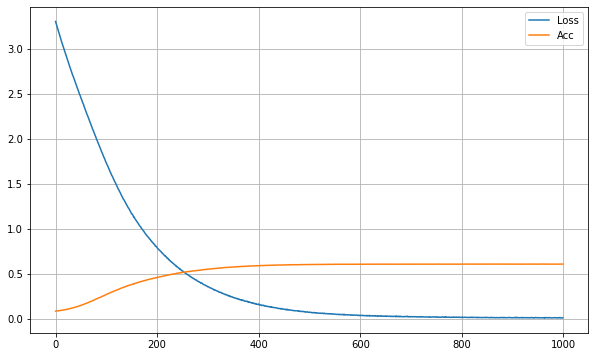

<Figure size 432x288 with 0 Axes>

In [176]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history.history['loss'], label='Loss') 
plt.plot(history.history['acc'], label='Acc') 
plt.legend() 
plt.show()
plt.savefig('output/acc_loss_2.png')

### Inference

In [177]:
from tensorflow.keras.models import model_from_json
# loading the model architecture and asigning the weights
json_file = open('output/PoemGen_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("output/PoemGen_model_weight_2.h5")

In [178]:
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs
# print(encoder_inputs.shape)
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [179]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_input_seq,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output
#print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [180]:
#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

In [181]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [182]:
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [183]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            break
        else:
            sampled_token = target_index2word[sampled_token_index]
            if(sampled_token !='end'):
                decoded_sentence += ' '+ sampled_token
                
            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_target_seq)):
                stop_condition = True

            # Update the ta`rget sequence (of length 1).
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = sampled_token_index

            # Update internal states
            e_h, e_c = h, c

    return decoded_sentence

In [184]:
for seq_index in [141, 2001, 3002]:
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_sentences[seq_index: seq_index + 1])
  print('Decoded sentence:', decoded_sentence)

-
Input sentence: ['song hồ nửa khép cánh mây']
Decoded sentence:  tường đông ghé mắt ngày ngày hằng trông
-
Input sentence: ['chiều nay hồn có trái sầu vừa rơi']
Decoded sentence:  không tình cũng nghĩa người ơi
-
Input sentence: ['từ trong tiền kiếp luân phiên dòng đời']
Decoded sentence:  hôm nay em trả nợ người


In [185]:
def make_a_poem_sentence(input_txt):
  input_seq = []
  for t, word in enumerate(input_txt.split()):
    input_seq.append(input_word2index[word])

  input_seq = np.array(input_seq)
  input_seq = pad_sequences([input_seq], maxlen=max_len_input_seq, padding='pre')
  decoded_txt = decode_sequence(input_seq)
  print('Generated poem sentence:', decoded_txt)

In [186]:
input_txt = 'chào cô em gái hái hoa'
make_a_poem_sentence(input_txt)

Generated poem sentence:  thươngthật lênh lênh màu ngàn qua yêu thương
